## Load In Dependencies

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("data/Training_data_uhi_index_UHI2025-v2.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

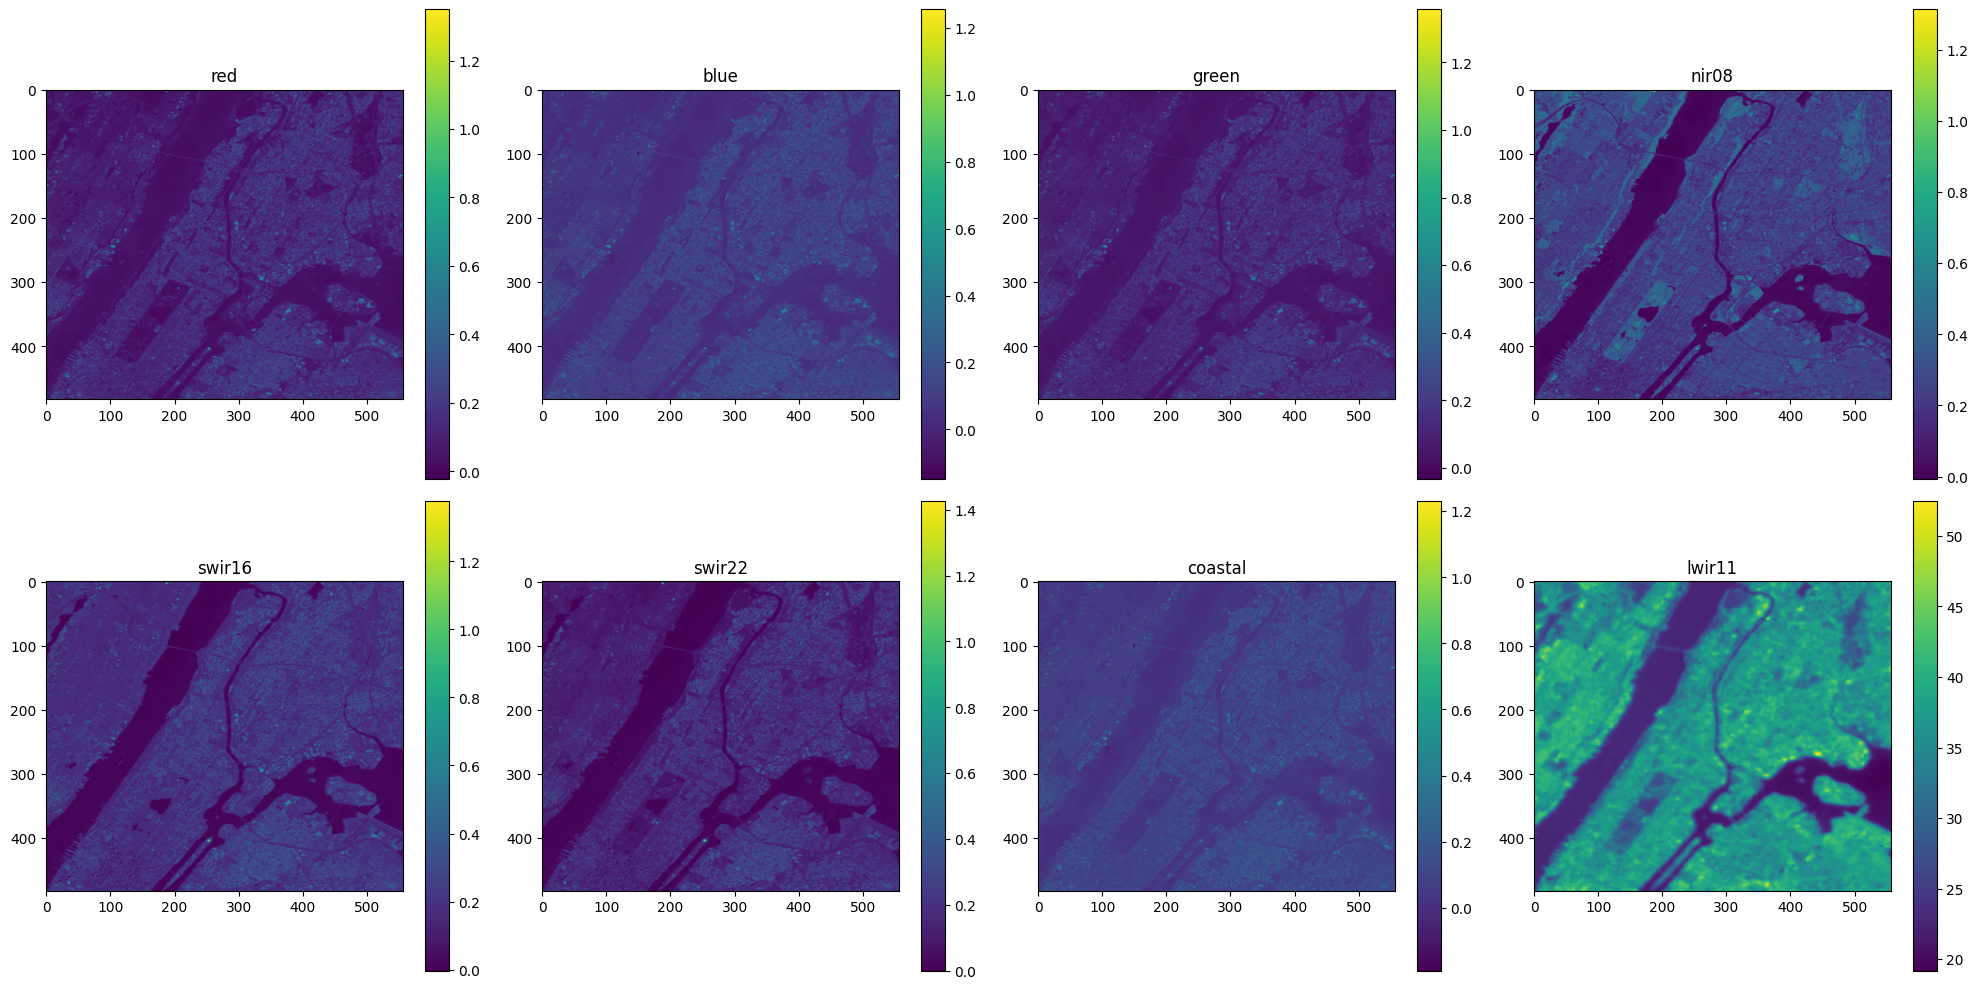

In [3]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "data_pipeline/data/tiff/landsat_8.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    red = dst.read(1)
    blue = dst.read(2)
    green = dst.read(3)
    nir08 = dst.read(4)
    swir16 = dst.read(5)
    swir22 = dst.read(6)
    coastal = dst.read(7) 
    lwir11 = dst.read(8)

band_name = ['red', 'blue', 'green', 'nir08', 'swir16', 'swir22', 'coastal', 'lwir11'] 
band_lst = [red, blue, green, nir08, swir16, swir22, coastal, lwir11]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


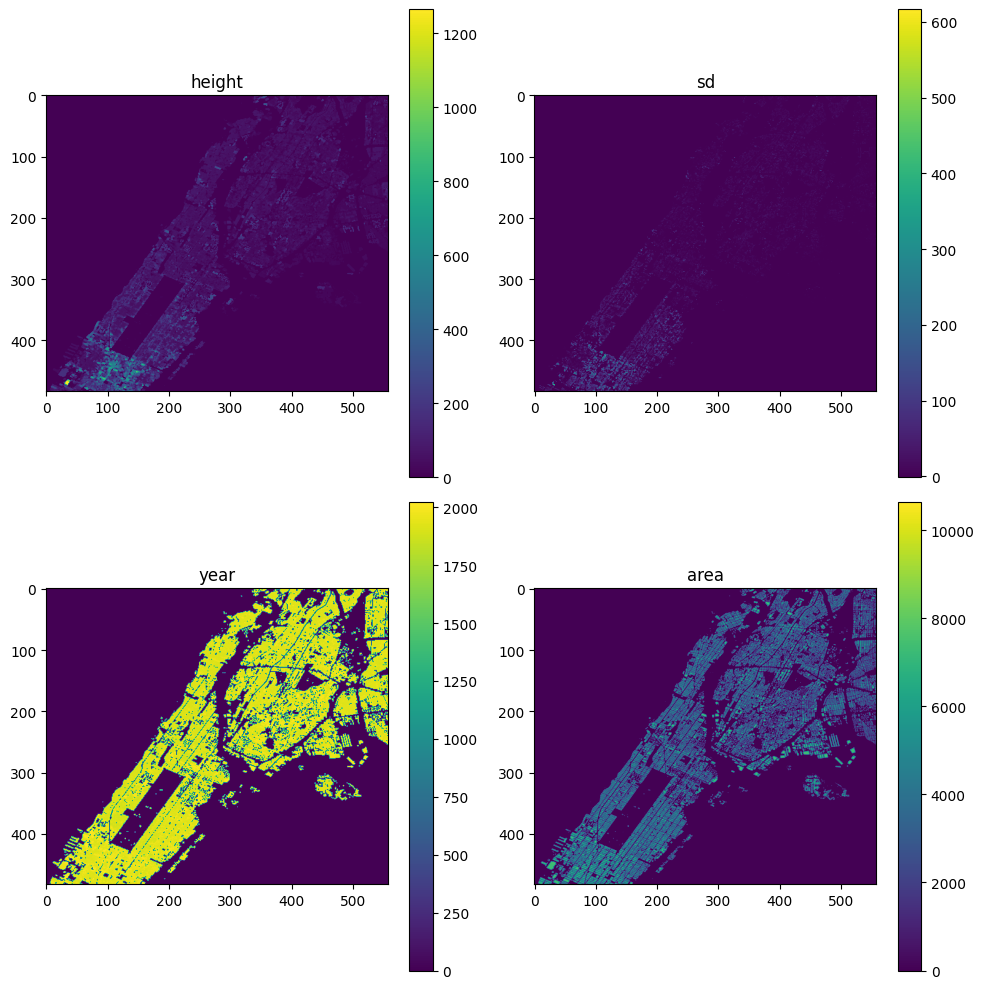

In [4]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "data_pipeline/data/tiff/building_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    building_height = dst.read(1)
    building_sd = dst.read(2)
    building_year = dst.read(3)
    building_area = dst.read(4)

band_name = ['height', 'sd', 'year', 'area']
band_lst = [building_height, building_sd, building_year, building_area]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


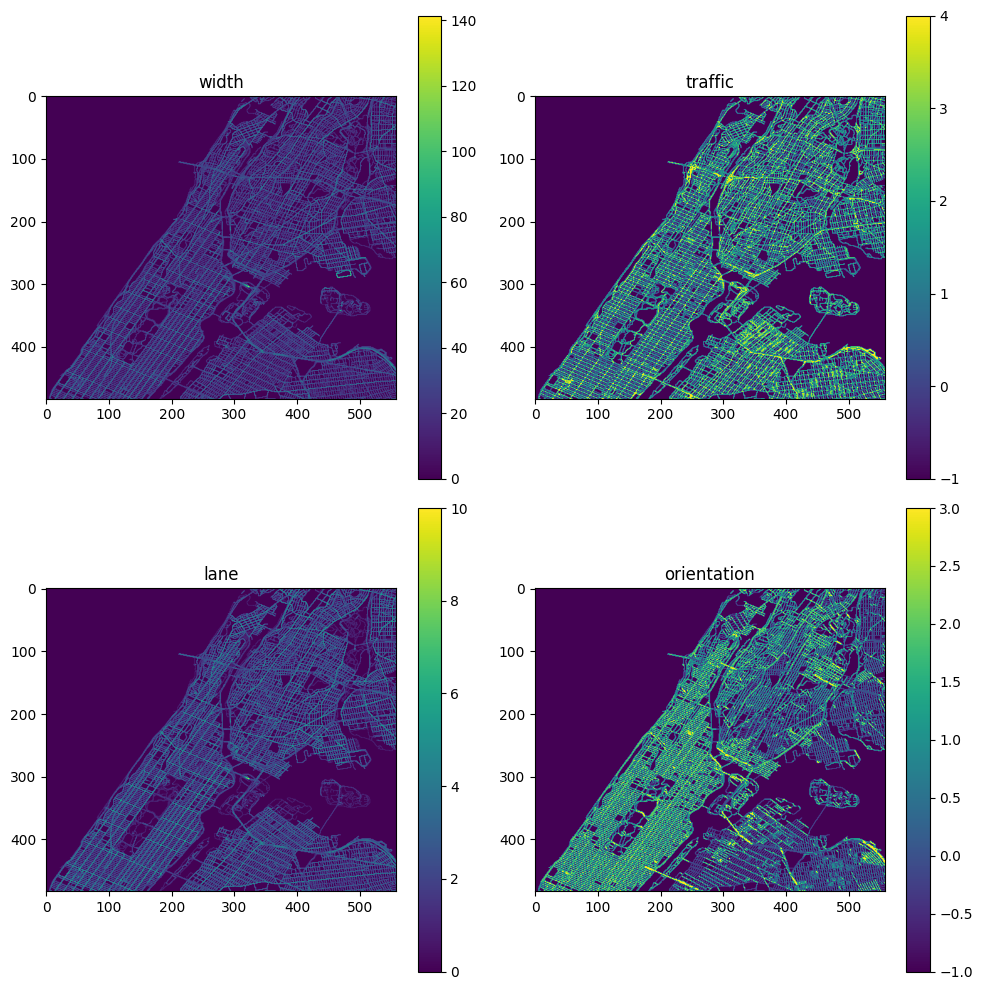

In [5]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "data_pipeline/data/tiff/street_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    street_width = dst.read(1)
    traffic_dir = dst.read(2)
    street_lane = dst.read(3)
    orientation = dst.read(4)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

band_lst = [street_width, traffic_dir, street_lane, orientation]
band_name = ['width', 'traffic', 'lane', 'orientation']
# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()





### Extracting Band Values from the GeoTIFF Image


In [6]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path, col_name):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    layer_num = 0
    with rasterio.open(tiff_path) as dts:
        layer_num = dts.count

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values   

    df = pd.DataFrame()
    for i in tqdm(range(layer_num), desc="Go through layer"):
        values = []
        # Iterate over the latitudes and longitudes, and extract the corresponding band values
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
            cell_value = data.sel(x=lon, y=lat,  band=i+1, method="nearest").values
            values.append(cell_value)
        # Add column of feature
        df[col_name[i]] = values
    
    return df


In [7]:
# Mapping satellite data with training data.
data_dir = "data_pipeline/data/tiff/"
landsat_bands = ['red', 'blue', 'green', 'nir08', 'swir16', 'swir22', 'coastal', 'lwir11']
landsat_data = map_satellite_data(data_dir+'landsat_8.tiff', 'data/Training_data_uhi_index_UHI2025-v2.csv',
                                landsat_bands)
landsat_data.head()

Go through layer: 100%|██████████| 8/8 [02:20<00:00, 17.58s/it]


,red,blue,green,nir08,swir16,swir22,coastal,lwir11
0,0.0713975,0.04560249999999999,0.06952750000000002,0.20887,0.13649,0.09543249999999998,0.03925000000000001,37.78553354000002
1,0.0713975,0.04560249999999999,0.06952750000000002,0.20887,0.13649,0.09543249999999998,0.03925000000000001,37.78553354000002
2,0.10783500000000001,0.08875,0.10676249999999998,0.23001749999999999,0.185,0.1352525,0.07574249999999999,37.35828104000001
3,0.10783500000000001,0.08875,0.10676249999999998,0.23001749999999999,0.185,0.1352525,0.07574249999999999,37.35828104000001
4,0.10783500000000001,0.08875,0.10676249999999998,0.23001749999999999,0.185,0.1352525,0.07574249999999999,37.35828104000001


In [8]:
# Mapping satellite data with training data.
building_bands = ['building_height', 'building_sd', 'building_year', 'building_area']
building_data = map_satellite_data(data_dir+'building_res30.tiff', 'data/Training_data_uhi_index_UHI2025-v2.csv',
                                building_bands)
building_data.head()

Mapping values:   0%|          | 0/11229 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 4/4 [00:56<00:00, 14.06s/it]


,building_height,building_sd,building_year,building_area
0,65.1,0.0,1928.0,936.1115
1,65.1,0.0,1928.0,936.1115
2,0.0,-1.0,0.0,0.0
3,0.0,-1.0,0.0,0.0
4,0.0,-1.0,0.0,0.0


In [9]:
# Mapping satellite data with training data.
street_bands = ['street_width', 'street_traffic', 'street_lane', 'street_orientation']
street_data = map_satellite_data(data_dir+'street_res30.tiff', 'data/Training_data_uhi_index_UHI2025-v2.csv',
                                street_bands)
street_data.head()

Go through layer:   0%|          | 0/4 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 4/4 [00:58<00:00, 14.70s/it]


,street_width,street_traffic,street_lane,street_orientation
0,44.0,4.0,4.0,1.0
1,44.0,4.0,4.0,1.0
2,31.0,1.0,2.3333333,1.0
3,31.0,1.0,2.3333333,1.0
4,31.0,1.0,2.3333333,1.0


In [10]:
df = pd.read_csv('data/Training_data_uhi_index_UHI2025-v2.csv')
df = pd.concat([df, landsat_data, building_data, street_data], axis=1)
df.head()

,Longitude,Latitude,datetime,UHI Index,red,blue,green,nir08,swir16,swir22,coastal,lwir11,building_height,building_sd,building_year,building_area,street_width,street_traffic,street_lane,street_orientation
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.0713975,0.04560249999999999,0.06952750000000002,0.20887,0.13649,0.09543249999999998,0.03925000000000001,37.78553354000002,65.1,0.0,1928.0,936.1115,44.0,4.0,4.0,1.0
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.0713975,0.04560249999999999,0.06952750000000002,0.20887,0.13649,0.09543249999999998,0.03925000000000001,37.78553354000002,65.1,0.0,1928.0,936.1115,44.0,4.0,4.0,1.0
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.10783500000000001,0.08875,0.10676249999999998,0.23001749999999999,0.185,0.1352525,0.07574249999999999,37.35828104000001,0.0,-1.0,0.0,0.0,31.0,1.0,2.3333333,1.0
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.10783500000000001,0.08875,0.10676249999999998,0.23001749999999999,0.185,0.1352525,0.07574249999999999,37.35828104000001,0.0,-1.0,0.0,0.0,31.0,1.0,2.3333333,1.0
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.10783500000000001,0.08875,0.10676249999999998,0.23001749999999999,0.185,0.1352525,0.07574249999999999,37.35828104000001,0.0,-1.0,0.0,0.0,31.0,1.0,2.3333333,1.0


In [11]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
df['ndvi'] = (df['nir08'] - df['red']) / (df['nir08'] + df['red'])
df['ndvi'] = df['ndvi'].replace([np.inf, -np.inf], np.nan)

df['albedo'] = 0.356 * df['blue'] + 0.130 * df['red'] + 0.373 * df['nir08'] + 0.085 * df['swir16'] + 0.072 * df['swir22'] - 0.018

## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [30]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
# columns_to_check = df.drop(columns=['Longitude', 'Latitude', 'datetime', 'UHI Index']).columns
columns = ['lwir11', 'building_height', 'building_year', 'ndvi', 'street_width', 'building_area']
uhi_data = df.copy()
for col in columns:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns, keep='first')
uhi_data.head()


,Longitude,Latitude,datetime,UHI Index,red,blue,green,nir08,swir16,swir22,...,building_height,building_sd,building_year,building_area,street_width,street_traffic,street_lane,street_orientation,ndvi,albedo
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.0713975,0.04560249999999999,0.06952750000000002,0.20887,0.13649,0.09543249999999998,...,65.099998,0.0,1928.0,936.111511,44.0,4.0,4.0,1.0,0.490505,0.103897
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.10783500000000001,0.08875,0.10676249999999998,0.23001749999999999,0.185,0.1352525,...,0.000000,-1.0,0.0,0.000000,31.0,1.0,2.3333333,1.0,0.361645,0.138873
6,-73.909312,40.812710,24-07-2021 15:53,1.015143,0.1826625,0.11226249999999999,0.15961750000000002,0.24583,0.22663500000000003,0.18719999999999998,...,12.830000,0.0,1931.0,33.707344,36.0,1.0,3.0,1.0,0.147418,0.170149
10,-73.909393,40.812403,24-07-2021 15:53,1.010815,0.19468000000000002,0.17191,0.18865749999999998,0.22506750000000003,0.27718,0.2440425,...,49.435001,1.0852995,1931.0,2639.544434,33.5,1.0,2.6666667,1.0,0.072395,0.19359
13,-73.909477,40.812163,24-07-2021 15:53,1.010815,0.19446000000000002,0.15436499999999997,0.1809575,0.241265,0.25056,0.22383000000000003,...,63.779999,0.0,1927.0,2716.260254,36.0,1.0,3.0,1.0,0.107419,0.189639


In [31]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [32]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
uhi_data = uhi_data.drop(columns=['datetime'])

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [33]:
# Split the data into features (X) and target (y), and then into training and testing sets
# columns = uhi_data.drop(columns=['UHI Index']).columns
X = uhi_data[columns].values
# X = uhi_data[['B01','B06','NDVI']]
y = uhi_data['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of B01, B06, NDVI variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

In [34]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<Axes: >

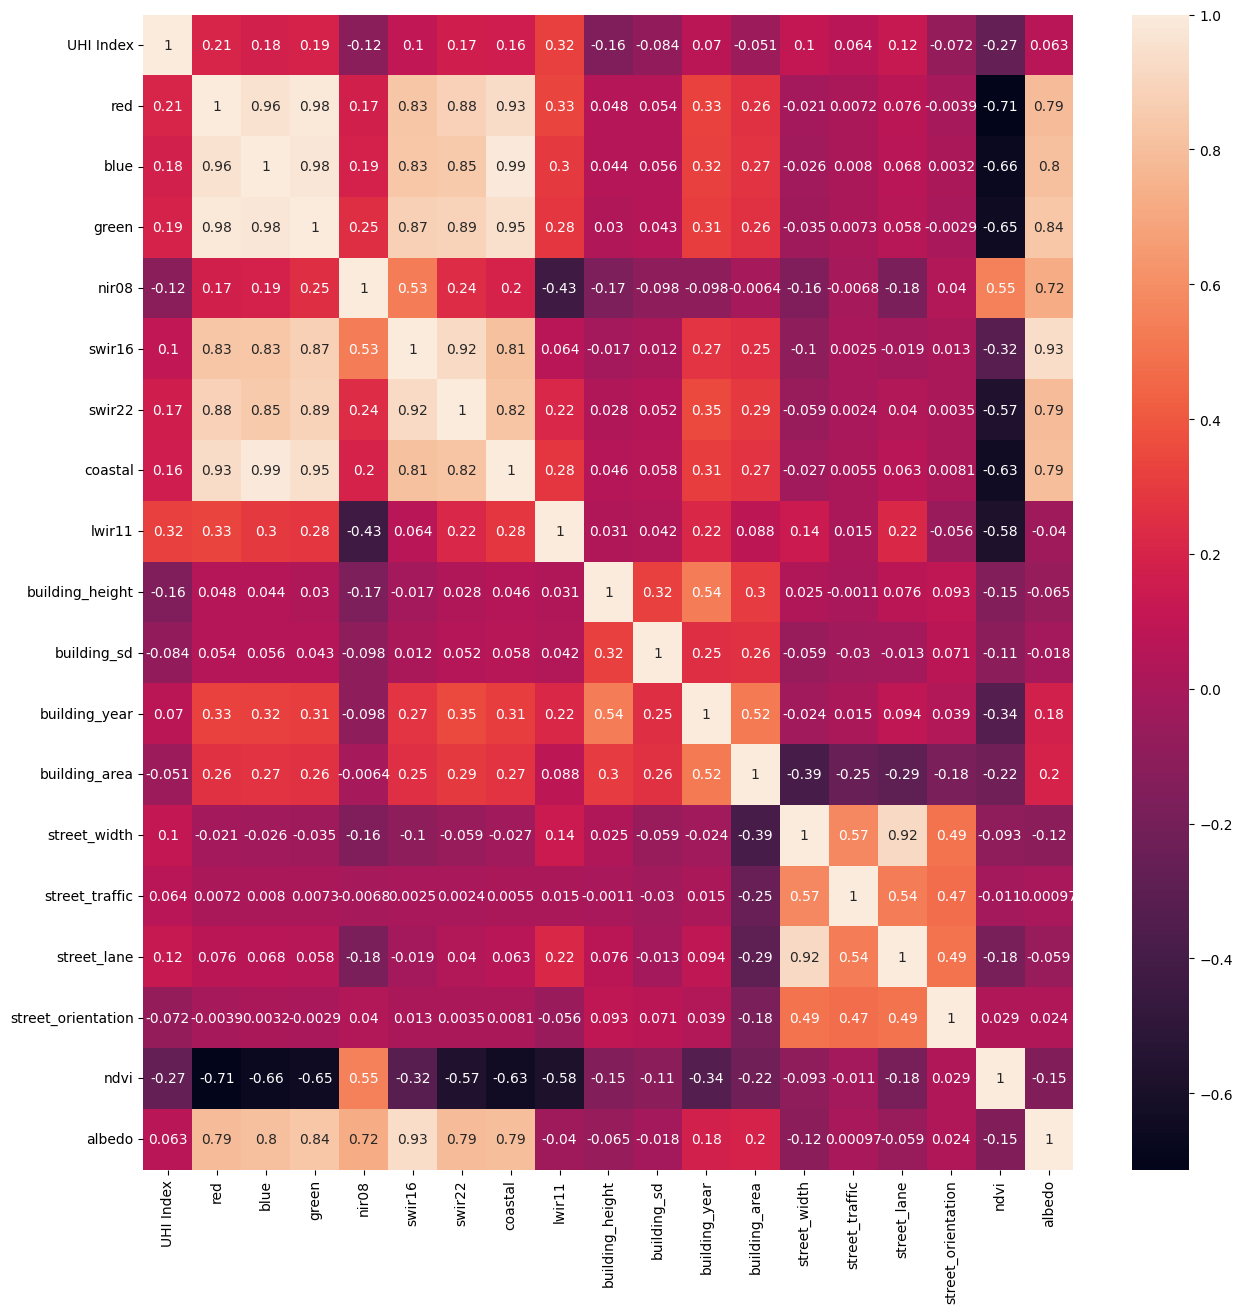

In [129]:
feat_corr = uhi_data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(feat_corr, annot=True)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [35]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [36]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [37]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9158880322350342

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [38]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [39]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.39798689923354547

In [40]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, Y_test, n_repeats=10, random_state=42)
print(result.importances_mean)

[0.2845346  0.289735   0.18100925 0.12831556 0.14496346 0.04477157]


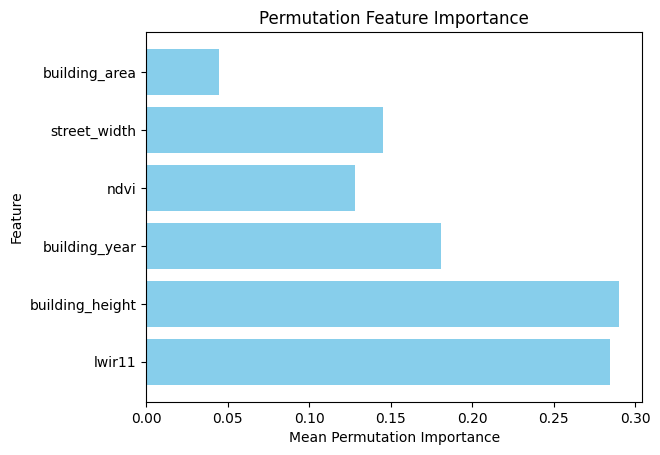

In [41]:
importance_mean = result.importances_mean

plt.barh(columns, importance_mean, color='skyblue')
plt.xlabel("Mean Permutation Importance")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.show()

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [135]:
#Reading the coordinates for the submission
test_file = pd.read_csv('data/Submission_template_UHI2025-v2.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [137]:
# Mapping satellite data for submission.
val_data1 = map_satellite_data(data_dir + 'landsat_8.tiff', 'data/Submission_template_UHI2025-v2.csv', landsat_bands)
val_data2 = map_satellite_data(data_dir + 'building_res30.tiff', 'data/Submission_template_UHI2025-v2.csv', building_bands)
val_data3 = map_satellite_data(data_dir + 'street_res30.tiff', 'data/Submission_template_UHI2025-v2.csv', street_bands)
val_data = pd.concat([val_data1, val_data2, val_data3], axis=1)

Go through layer:   0%|          | 0/8 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


In [138]:
val_data['ndvi'] = (val_data['nir08'] - val_data['red']) / (val_data['nir08'] + val_data['red'])
val_data['ndvi'] = val_data['ndvi'].replace([np.inf, -np.inf], np.nan)

val_data['albedo'] = 0.356 * val_data['blue'] + 0.130 * val_data['red'] + 0.373 * val_data['nir08'] + 0.085 * val_data['swir16'] + 0.072 * val_data['swir22'] - 0.018

In [170]:
val_data.head()

,red,blue,green,nir08,swir16,swir22,coastal,lwir11,building_height,building_sd,building_year,building_area,street_width,street_traffic,street_lane,street_orientation,ndvi,albedo
0,0.061580000000000024,0.05170750000000002,0.07354250000000001,0.2785275,0.15694999999999998,0.09744000000000003,0.0476375,36.202990279999995,62.0,0.0,1989.0,2369.9119,30.0,4.0,3.0,3.0,0.637879,0.13266
1,0.061580000000000024,0.05170750000000002,0.07354250000000001,0.2785275,0.15694999999999998,0.09744000000000003,0.0476375,36.202990279999995,62.0,0.0,1989.0,63.584137,30.0,4.0,3.0,3.0,0.637879,0.13266
2,0.1432,0.11163000000000001,0.1309075,0.1695175,0.17394500000000002,0.16019499999999998,0.09994249999999999,36.069687499999986,235.43724,0.0,1931.0,4479.868,0.0,-1.0,0.0,-1.0,0.084157,0.129906
3,0.1856875,0.13085249999999998,0.17215750000000002,0.22102500000000003,0.23373,0.2094475,0.11088750000000003,36.886594280000054,70.91,12.13869,1905.8,1932.5002,30.0,4.0,3.0,3.0,0.086886,0.170112
4,0.12166749999999998,0.12287749999999997,0.12205250000000001,0.2677475,0.22218,0.16286250000000002,0.12026500000000001,34.50081632000001,52.617714,7.3591685,1893.1428,2381.5554,32.0,4.0,3.0,3.0,0.375127,0.172042


In [171]:
# Feature Scaling 
submission_val_data = val_data[columns].values
transformed_submission_data = sc.transform(submission_val_data)

In [172]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [173]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [174]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.981929
1,-73.971928,40.788875,0.971450
2,-73.967080,40.789080,0.969587
3,-73.972550,40.789082,0.996007
4,-73.969697,40.787953,0.963253


In [175]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submissions/landsat_6features.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>